# Description

A simple model to predict a stock's price given its recent price history.


# Versions
## v1
- Context window: 8 days price history
- Linear model predicts next day price
- L2 loss
- Naive strategy of holding stock iff predicted price for day went up
- Table comparing return vs baselines: always hold, and mean price predictor

In [1]:
from matplotlib import pyplot as plt

%matplotlib inline

import pandas as pd
import torch as th
import numpy as np

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

# Dataset

In [2]:
from dataclasses import dataclass

batch_size = 128
hist_win = 8
pred_win = 1

@dataclass
class DateRange:
  """Specifies a range of dates, using [start, end)."""
  start: str = None
  end: str = None

train_date_range = DateRange('2003-01-01', '2017-01-01')
eval_date_range = DateRange('2017-01-01', '2020-01-01')

In [3]:
def load_df(ticker, date_range: DateRange):
  """Loads the DataFrame for ticker between [start_date, end_date)."""
  df = pd.read_csv(f'~/data/stock/kaggle/full_history/{ticker}.csv')
  df['date'] = pd.to_datetime(df['date'])
  if date_range.start:
    df = df.query(f'date >= "{date_range.start}"')
  if date_range.end:
    df = df.query(f'date < "{date_range.end}"')
  # reverse so oldest is first
  df = df.iloc[::-1].reset_index(drop=True)
  return df

df = load_df('GOOG', train_date_range)
df.head(10)

,date,volume,open,high,low,close,adjclose
0,2004-08-19,44871300,49.813286,51.835709,47.800831,49.982655,49.982655
1,2004-08-20,22942800,50.316402,54.336334,50.062355,53.952770,53.952770
2,2004-08-23,18342800,55.168217,56.528118,54.321388,54.495735,54.495735
3,2004-08-24,15319700,55.412300,55.591629,51.591621,52.239193,52.239193
4,2004-08-25,9232100,52.284027,53.798351,51.746044,52.802086,52.802086
5,2004-08-26,7128600,52.279045,53.773445,52.134586,53.753517,53.753517
6,2004-08-27,6241200,53.848164,54.107193,52.647663,52.876804,52.876804
7,2004-08-30,5221400,52.443428,52.548038,50.814533,50.814533,50.814533
8,2004-08-31,4941200,50.958992,51.661362,50.889256,50.993862,50.993862
9,2004-09-01,9181600,51.158245,51.292744,49.648903,49.937820,49.937820


In [4]:
df.tail(10)

,date,volume,open,high,low,close,adjclose
3105,2016-12-16,2443800,800.400024,800.856018,790.289978,790.799988,790.799988
3106,2016-12-19,1232100,790.219971,797.659973,786.270020,794.200012,794.200012
3107,2016-12-20,951000,796.760010,798.650024,793.270020,796.419983,796.419983
3108,2016-12-21,1211300,795.840027,796.676025,787.099976,794.559998,794.559998
3109,2016-12-22,972200,792.359985,793.320007,788.580017,791.260010,791.260010
3110,2016-12-23,623400,790.900024,792.739990,787.280029,789.909973,789.909973
3111,2016-12-27,789100,790.679993,797.859985,787.656982,791.549988,791.549988
3112,2016-12-28,1153800,793.700012,794.229980,783.200012,785.049988,785.049988
3113,2016-12-29,744300,783.330017,785.929993,778.919983,782.789978,782.789978
3114,2016-12-30,1770000,782.750000,782.780029,770.409973,771.820007,771.820007


In [5]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Caveats
#   - looks at only 1 column
class StockSeqDataset(Dataset):
    def __init__(self, df, column='adjclose', hist_win=hist_win, pred_win=pred_win):
        self.df = df
        self.col = column
        self.hist_win = hist_win
        self.pred_win = pred_win
    
    def __getitem__(self, index):
        assert 0 <= index < len(self)
        x_end = index + self.hist_win
        x = self.df.iloc[index:x_end][self.col]
        y = self.df.iloc[x_end:x_end+self.pred_win][self.col]
        return (th.from_numpy(np.array(x, dtype=np.float32)),
                th.from_numpy(np.array(y, dtype=np.float32)))
    
    def __len__(self):
        return len(self.df) - self.hist_win - self.pred_win + 1

ds = StockSeqDataset(df)

dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)

In [6]:
ds[0]

(tensor([49.9827, 53.9528, 54.4957, 52.2392, 52.8021, 53.7535, 52.8768, 50.8145]),
 tensor([50.9939]))

In [7]:
for x, y in dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 8])
torch.Size([128, 1])


# Model

In [8]:
model = th.nn.Sequential(
    th.nn.Linear(hist_win, pred_win),
    #th.nn.ReLU(),
    #th.nn.Linear(100, pred_win),
)

loss_fn = th.nn.MSELoss()

learning_rate = 0.005
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.5))
lr_schedule = th.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

steps = 50
for epoch in range(steps):
    loss_avg = 0
    for x, y in dl:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
        #print(loss.item())
    lr_schedule.step()
    print(f'{lr_schedule.get_lr()[0]:.5f} {loss_avg / len(dl)}')

/home/z/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:425: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


0.00405 3428.3155012512207
0.00365 86.99801177978516
0.00328 80.5629133605957
0.00295 80.13662170410156
0.00266 78.19007507324218
0.00239 76.86401763916015
0.00215 75.29032745361329
0.00194 75.60912185668946
0.00174 76.36066909790038
0.00157 73.15467315673828
0.00141 72.4154948425293
0.00127 71.13162017822266
0.00114 70.34543197631837
0.00103 68.91767486572266
0.00093 69.52172637939454
0.00083 67.99587966918945
0.00075 68.44377990722656
0.00068 68.93886093139649
0.00061 66.97103607177735
0.00055 67.7565592956543
0.00049 66.57399551391602
0.00044 67.20559158325196
0.00040 66.72162620544434
0.00036 66.24928039550781
0.00032 64.75654823303222
0.00029 69.96399520874023
0.00026 64.71116348266601
0.00024 66.7393571472168
0.00021 68.31582229614258
0.00019 64.47771362304688
0.00017 66.26123611450195
0.00015 65.34037841796875
0.00014 64.89490585327148
0.00013 64.2680599975586
0.00011 64.10105621337891
0.00010 63.80478302001953
0.00009 63.6213419342041
0.00008 65.02284835815429
0.00007 63.976493

In [9]:
lr_schedule.get_lr()

[2.3191988432940557e-05]

In [10]:
y.t()

tensor([[187.0539, 166.4063,  93.6390, 234.8746, 581.0647, 286.0179, 310.3617,
          85.9528, 523.4000, 432.5338, 274.0229, 457.5600,  89.2903, 208.1897,
         344.2746,  89.4497, 303.5921, 141.4946, 208.0701, 209.9431, 254.4861,
         244.9419, 699.5600, 348.3692, 237.6692, 183.8509, 458.4018, 255.6717,
         227.4276, 230.9444, 240.6032, 207.8360, 443.6620, 266.0179, 302.8548]])

In [11]:
model(x).t()

tensor([[192.8963, 158.0837,  97.5889, 233.8664, 585.6243, 288.5129, 308.8554,
          90.2777, 525.2061, 441.8520, 284.3418, 456.8186,  89.3508, 211.2000,
         341.9984,  89.7095, 303.6370, 144.7435, 204.8161, 207.8979, 255.0943,
         239.2471, 703.0855, 352.0005, 246.2082, 189.6337, 449.9195, 253.7966,
         223.4513, 228.5066, 243.9498, 202.7342, 446.5865, 261.3202, 298.7997]],
       grad_fn=<TBackward>)

# Baseline Models

In [12]:
class MeanModel(th.nn.Module):
    def forward(self, x):
        return x.mean(dim=-1).unsqueeze(axis=1)

# Validation

In [13]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1410,  0.0774, -0.2343,  0.3322, -0.1598,  0.1632,  0.2747,  0.4078]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.1568], requires_grad=True)]

In [14]:
def validate(model, ticker):
  assert pred_win == 1
  df = load_df(ticker, eval_date_range)
  ds = StockSeqDataset(df)
  dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
  for i, (x, y) in enumerate(dl):
    start = batch_size * i + hist_win  # prediction is offset by hist_win
    end = start + batch_size - 1  # slice end is inclusive
    with th.no_grad():
      y_pred = model(x)
    y = y.cpu().numpy().squeeze()
    y_pred = y_pred.cpu().numpy().squeeze()
    #import pdb; pdb.set_trace()
    df.loc[start:end, 'actual'] = y
    df.loc[start:end, 'pred'] = y_pred
  return df

def plot(df, cols=['actual', 'pred']):
 df.plot(x='date', y=cols, figsize=(10, 8))

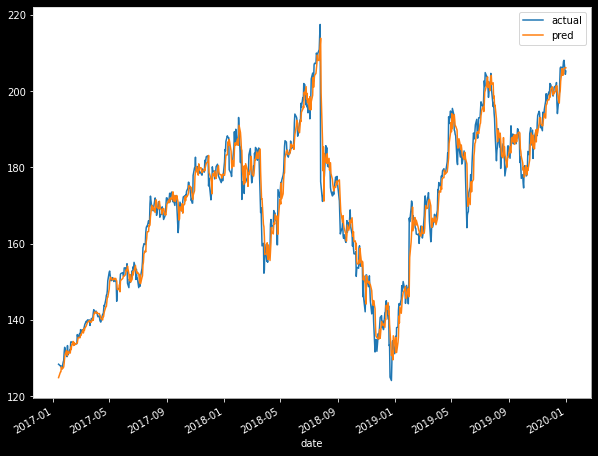

In [15]:
df_pred = validate(model, 'FB')
plot(df_pred)

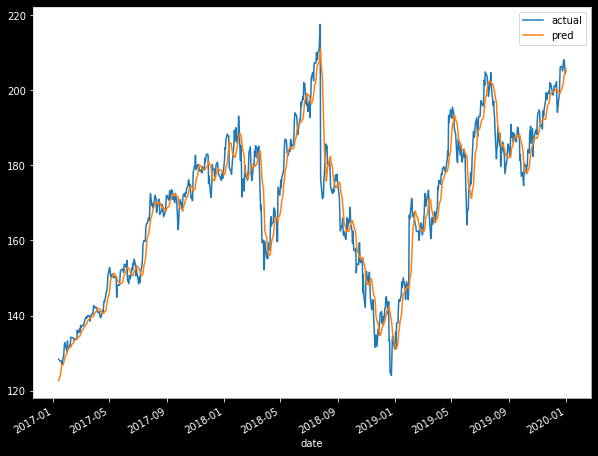

In [16]:
df_pred = validate(MeanModel(), 'FB')
plot(df_pred)

# Strategy

In [21]:
class SimpleStrategy:
  """Simple strategy

  If day's predicted change is positive, hold through day.
  If day's predicted change is negative, skip the day.
  """
  def __init__(self, model):
    self.model = model

  def compute_hold(self, ticker):
    df_pred = validate(self.model, ticker)
    df_pred = df_pred.dropna(subset=('actual', 'pred'))
    actual, pred = df_pred['actual'].values, df_pred['pred'].values
    assert len(actual) == len(pred)
    hold = pred[1:] > pred[:-1]
    return pd.DataFrame.from_dict({
        'actual': actual[1:],
        'pred': pred[1:],
        'hold': hold,
    })

def compute_returns(df):
  df = df.copy()
  df.loc[:, 'roi_actual'] = df.actual / df.actual.shift(1)
  df.loc[:, 'roi_pred'] = df.pred / df.pred.shift(1)
  return df

def total_return(df, query=None):
  if query:
    df = df.query(query)
  roi_actual = df.roi_actual.product()
  roi_pred = df.roi_pred.product()
  return roi_actual, roi_pred

def evaluate_models(models, tickers):
  strats = {name: SimpleStrategy(model) for name, model in models.items()}
  df_actual = pd.DataFrame()
  df_pred = pd.DataFrame()
  
  for ticker in tickers:
    for strat_name, strat in strats.items():
      df_hold = strat.compute_hold(ticker)
      df_roi = compute_returns(df_hold)
      
      all = total_return(df_roi)
      hold = total_return(df_roi, 'hold == True')
      not_hold = total_return(df_roi, 'hold == False')

      df_actual.loc[strat_name + ': all', ticker] = all[0]
      df_actual.loc[strat_name + ': hold', ticker] = hold[0]
      df_actual.loc[strat_name + ': !hold', ticker] = not_hold[0]
      df_pred.loc[strat_name + ': all', ticker] = all[1]
      df_pred.loc[strat_name + ': hold', ticker] = hold[1]
      df_pred.loc[strat_name + ': !hold', ticker] = not_hold[1]
  return df_actual, df_pred


In [23]:
models = {
    'mean': MeanModel(),
    'linear': model,
}
tickers = [
    'FB',
    'GOOG',
    'AAPL',
    'MSFT',
    'SPY',
]

df_actual, df_pred = evaluate_models(models, tickers)
df_actual

,FB,GOOG,AAPL,MSFT,SPY
mean: all,1.605146,1.661700,2.561683,2.661719,1.505773
mean: hold,1.191728,0.858175,1.725186,1.198619,1.311940
mean: !hold,1.346907,1.936317,1.484874,2.220654,1.147745
linear: all,1.605146,1.661700,2.561683,2.661719,1.505773
linear: hold,0.866311,1.181861,1.794416,1.299995,1.332203
linear: !hold,1.852851,1.406002,1.427586,2.047484,1.130287
